### Plotting the alignability of centrolign with respect to distance from the CDR

In [1]:
import pandas as pd
import os
import glob

### Chr 11 test case 

In [17]:
import pandas as pd
import glob
import os

import pandas as pd
import glob
import os

def read_bedtools_subset(bed_dir):
    dfs = []

    bed_files = glob.glob(os.path.join(bed_dir, "*.bed"))

    for bed in bed_files:
        df = pd.read_csv(
            bed,
            sep="\t",
            header=None,
            usecols=[0, 1, 2, 3, 4, 6, 14],  
            names=["contig", "start", "end", "prop_aligned", "n_pairs", "cdr_start", "dist_to_cdr"]
        )
        df["source_file"] = os.path.basename(bed)  # optional
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)



In [15]:
bed_dir = "/private/groups/patenlab/mira/windowed_alignment_beds_asm_coords/CDR_distance"
df = read_bedtools_subset(bed_dir)

print(df.head())
print(df.shape)


ParserError: Defining usecols with out-of-bounds indices is not allowed. [14] are out of bounds.

/data/tmp/ipykernel_678993/36520966.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = df_plot.groupby("bin")["prop_aligned"].mean().reset_index()


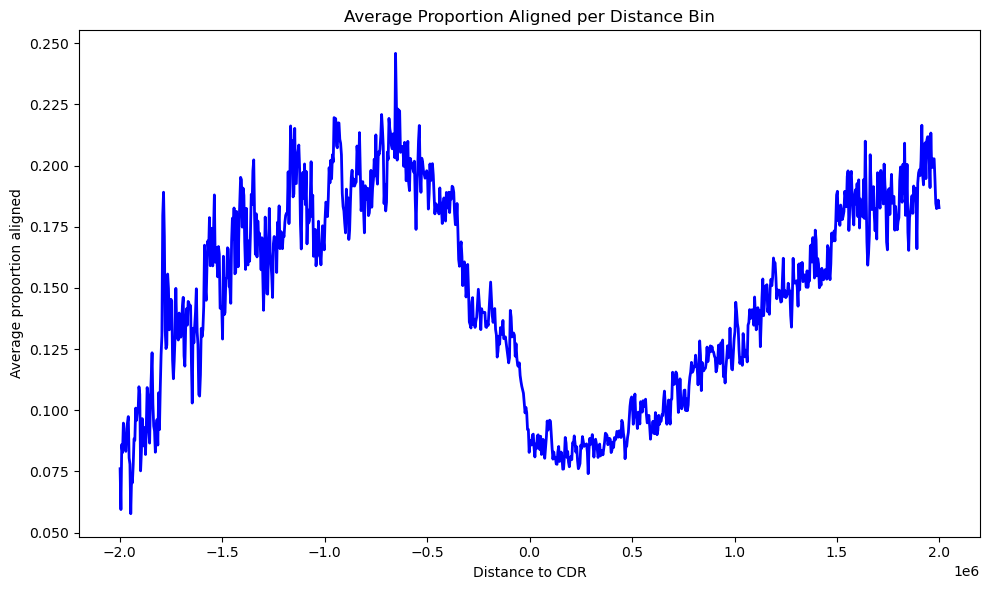

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter invalid distances and restrict to -100k to +100k
df_plot = df[(df["dist_to_cdr"] != -1) &
             (df["dist_to_cdr"] >= -2_000_000) &
             (df["dist_to_cdr"] <= 2_000_000)].copy()

# Define bins
num_bins = 1000
bins = np.linspace(-2_000_000, 2_000_000, num_bins + 1)

# Bin the distances
df_plot["bin"] = pd.cut(df_plot["dist_to_cdr"], bins=bins, include_lowest=True)

# Compute average proportion aligned per bin
bin_avg = df_plot.groupby("bin")["prop_aligned"].mean().reset_index()

# Get bin centers for plotting
bin_avg["bin_center"] = bin_avg["bin"].apply(lambda x: x.mid)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(bin_avg["bin_center"], bin_avg["prop_aligned"], color="blue", linewidth=2)
plt.xlabel("Distance to CDR")
plt.ylabel("Average proportion aligned")
plt.title("Average Proportion Aligned per Distance Bin")
#plt.xlim(-100_000, 100_000)
plt.tight_layout()
plt.show()



### Subsetting to pairs with dist < 0.4 

In [18]:
bed_dir = "/private/groups/patenlab/mira/windowed_alignment_beds_asm_coords_dist0.4/CDR_distance"
df = read_bedtools_subset(bed_dir)

print(df.head())
print(df.shape)


                 contig     start       end  prop_aligned  n_pairs  cdr_start  \
0  HG02514#2#CM098752.1  50767034  50767084      1.000000       26         -1   
1  HG02514#2#CM098752.1  50767084  50767134      1.000000       26         -1   
2  HG02514#2#CM098752.1  50767134  50767184      1.000000       26         -1   
3  HG02514#2#CM098752.1  50767184  50767234      1.000000       26         -1   
4  HG02514#2#CM098752.1  50767234  50767284      0.999231       26         -1   

   dist_to_cdr                                source_file  
0           -1  HG02514.2.windowed_alignment.CDR_dist.bed  
1           -1  HG02514.2.windowed_alignment.CDR_dist.bed  
2           -1  HG02514.2.windowed_alignment.CDR_dist.bed  
3           -1  HG02514.2.windowed_alignment.CDR_dist.bed  
4           -1  HG02514.2.windowed_alignment.CDR_dist.bed  
(7898912, 8)


Distance range: -3242686 to 3951887


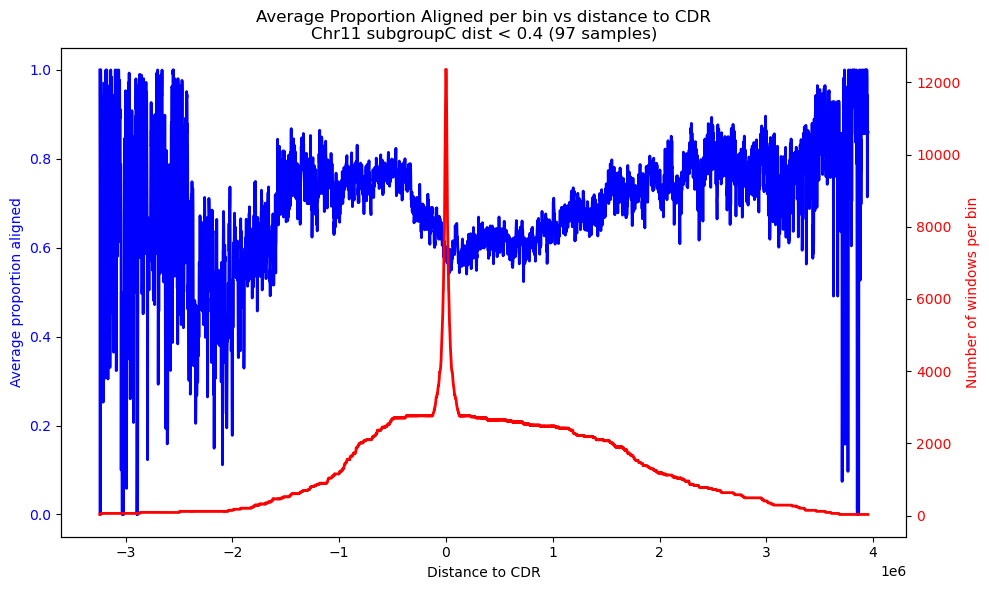

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter for no CDR intersections found
df_plot = df[df["cdr_start"] != -1].copy()

# Calculate number of unique contigs
num_unique_contigs = df_plot["contig"].nunique()

# Determine dynamic range from data
min_dist = df_plot["dist_to_cdr"].min()
max_dist = df_plot["dist_to_cdr"].max()
print(f"Distance range: {min_dist} to {max_dist}")

# Define bins dynamically
num_bins = 5000
bins = np.linspace(min_dist, max_dist, num_bins + 1)

# Bin the distances
df_plot["bin"] = pd.cut(
    df_plot["dist_to_cdr"],
    bins=bins,
    include_lowest=True
)

# Aggregate per bin
bin_stats = (
    df_plot
    .groupby("bin", observed=True)
    .agg(
        prop_aligned_mean=("prop_aligned", "mean"),
        n_rows=("dist_to_cdr", "size")  # number of rows per bin
    )
    .reset_index()
)

# Bin centers for plotting
bin_stats["bin_center"] = bin_stats["bin"].apply(lambda x: x.mid)

# Optionally exclude dist=0 bin for secondary axis
zero_bin_mask = bin_stats["bin"].apply(lambda x: x.left <= 0 <= x.right)
bin_stats.loc[zero_bin_mask, "n_rows"] = np.nan

# -----------------------------
# Plot
# -----------------------------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left axis: average proportion aligned
ax1.plot(
    bin_stats["bin_center"],
    bin_stats["prop_aligned_mean"],
    color="blue",
    linewidth=2
)
ax1.set_xlabel("Distance to CDR")
ax1.set_ylabel("Average proportion aligned", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Right axis: number of rows per bin
ax2 = ax1.twinx()
ax2.plot(
    bin_stats["bin_center"],
    bin_stats["n_rows"],
    color="red",
    linewidth=2
)
ax2.set_ylabel("Number of windows per bin", color="red")
ax2.tick_params(axis="y", labelcolor="red")

plt.title(f"Average Proportion Aligned per bin vs distance to CDR\nChr11 subgroupC dist < 0.4 ({num_unique_contigs} samples)")

fig.tight_layout()
plt.show()

